In [2]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import cartopy.crs as ccrs

import shapefile

# Masking the original file (ncells) directly with shapefile  
#### README
#### Check the information of lonlat in original file is inside the polygon file of shapefile

## 1. Load the shapefile for the Amazon basin

In [2]:
# load the original masking shapefile for Amazon basin
sf = shapefile.Reader("/work/mh0731/m300948/AMDEF/REGRID_BC/amazon_sensulatissimo_gmm_v1.shp")

In [3]:
print(sf)

shapefile Reader
    10 shapes (type 'POLYGON')


In [4]:
# you can get a list of the shapefile's geometry by calling the shapes() method
shapes = sf.shapes()

In [ ]:
# check lon/ lat values for the shapefile
for shape in shapes:
    print(shape.points) # lon lat

In [6]:
from matplotlib.patches import Polygon
paths = [Polygon(shape.points).get_path() for shape in shapes]

## 2. Load the original data (ncells) what I want to convert - bc_land

In [8]:
#path_ori =Path('/work/mh0731/m300948/AMDEF/REGRID_BC/bc_land_soil_2015.nc')
path_ori =Path('/work/mh0731/m300948/AMDEF/REGRID_BC/amz_ori/bc_land_frac_2015.nc')

#dset_ori = xr.open_dataset(path_ori)
dset_ori = xr.open_dataset(path_ori)

In [9]:
# get the lon, lat information from the original data into degree (to match with the shapefile)
cellpoints = np.rad2deg(np.stack([dset_ori.clon.values, dset_ori.clat.values], axis=-1))

In [20]:
# check if it has a same order of lon, lat as the shapefile (so that we can match it easily)
cellpoints.max()

-179.99998218848881

## 3. Check lon/lat in the original file is in inside the polygon

In [10]:
import functools
mask = functools.reduce(lambda a,b: a|b, (path.contains_points(cellpoints) for path in paths))

# this process can be into true/false

In [26]:
# check the percentage of points which is inside the polygon file
mask.mean()

0.014143419265747071

## 4. if it is True, then change the value into "new value"

In [32]:
dset_new = xr.Dataset({
    "veg_ratio_max": dset_ori.root_depth.where(~mask,0.85),
})
dset_new

<xarray.Dataset>
Dimensions:     (cell: 20971520)
Coordinates:
    clon        (cell) float64 1.274 1.275 1.273 1.274 ... 1.335 1.336 1.334
    clat        (cell) float64 0.9182 0.9185 0.9185 ... -0.7884 -0.7894 -0.7895
Dimensions without coordinates: cell
Data variables:
    root_depth  (cell) float64 1.119 1.161 1.094 1.103 1.176 ... 0.3 0.3 0.3 0.3

## 5. Check whether it is well masked with plotting (without remapping)

In [30]:
import numpy as np
from scipy.interpolate import NearestNDInterpolator

lon = np.deg2rad(np.linspace(-180, 180, 600))
lat = np.deg2rad(np.linspace(-90, 90, 300))
lon2, lat2 = np.meshgrid(lon, lat)

points_icon = np.vstack((dset_ori.clon, dset_ori.clat)).T

nn_interpolation = NearestNDInterpolator(points_icon, root_depth_new.values)
interpolated_nn = nn_interpolation((lon2, lat2))

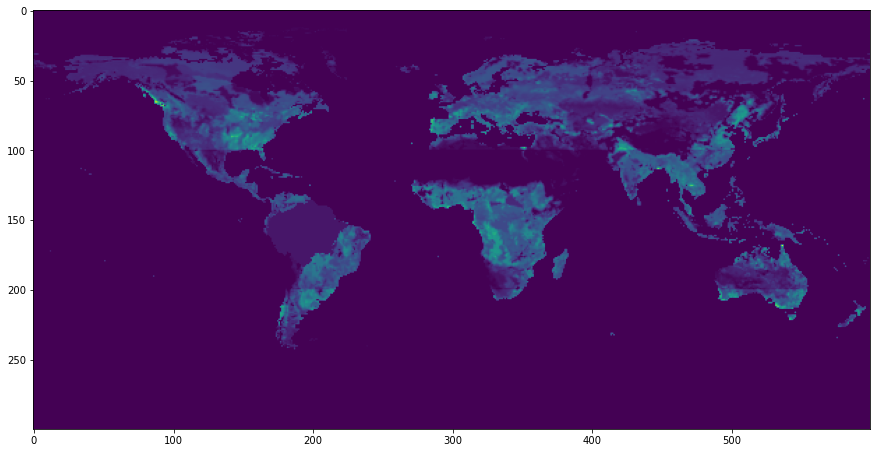

In [31]:
import matplotlib.pylab as plt

plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## 6. Save it into new netcdf file

In [ ]:
dset_new.to_netcdf("/work/mh0731/m300948/AMDEF/REGRID_BC/amz_100def/scena_100_implement/bc_land_frac_new.nc")

## 7. Plotting final data

In [3]:
# land-sea mask
path_landsea =Path('/work/mh0731/m300948/AMDEF/REGRID_BC/amz_100def/scena_100_implement/cell_sea_land_mask_remap.nc')
dset_landsea = xr.open_dataset(path_landsea)

In [7]:
dset_landsea

<xarray.Dataset>
Dimensions:             (lon: 7200, lat: 3600)
Coordinates:
  * lon                 (lon) float64 -179.9 -179.9 -179.8 ... 179.9 180.0 180.0
  * lat                 (lat) float64 -89.95 -89.9 -89.85 ... 89.9 89.95 90.0
Data variables:
    cell_sea_land_mask  (lat, lon) int32 ...
Attributes: (12/44)
    CDI:                      Climate Data Interface version 2.0.3 (https://m...
    Conventions:              CF-1.6
    source:                   git@git.mpimet.mpg.de:GridGenerator.git
    institution:              Max Planck Institute for Meteorology/Deutscher ...
    title:                    ICON grid description
    revision:                 d00fcac1f61fa16c686bfe51d1d8eddd09296cb5
    ...                       ...
    topography:               modified SRTM30
    subcentre:                1
    history:                  Tue Oct 04 16:33:15 2022: cdo -remap,griddes_05...
    ICON_grid_file_uri:       http://icon-downloads.mpimet.mpg.de/grids/publi...
    NCO:                      netCDF Operators version 4.7.5 (Homepage = http...
    CDO:                      Climate Data Operators version 2.0.3 (https://m...

In [14]:
path_convert =Path('/work/mh0731/m300948/AMDEF/REGRID_BC/amz_100def/scena_100_implement/bc_land_phys_final_remap.nc')
dset_convert = xr.open_dataset(path_convert)

In [15]:
dset_convert

<xarray.Dataset>
Dimensions:               (time: 12, lon: 7200, lat: 3600)
Coordinates:
  * time                  (time) object 0001-01-31 00:00:00 ... 0001-12-31 00...
  * lon                   (lon) float64 -179.9 -179.9 -179.8 ... 180.0 180.0
  * lat                   (lat) float64 -89.95 -89.9 -89.85 ... 89.9 89.95 90.0
Data variables:
    lai_clim              (time, lat, lon) float64 ...
    veg_fract             (time, lat, lon) float64 ...
    roughness_length      (lat, lon) float64 ...
    roughness_length_oro  (lat, lon) float64 ...
    albedo                (lat, lon) float64 ...
    albedo_veg_vis        (lat, lon) float64 ...
    albedo_veg_nir        (lat, lon) float64 ...
    albedo_soil_vis       (lat, lon) float64 ...
    albedo_soil_nir       (lat, lon) float64 ...
    forest_fract          (lat, lon) float64 ...
Attributes: (12/16)
    CDI:                          Climate Data Interface version 2.0.3 (https...
    Conventions:                  CF-1.0
    institution:                  Max Planck Institute for Meteorology
    title:                        initial surface data for JSBACH
    refyear_for_cover_types:      2015
    refyear_for_cover_fractions:  2015
    ...                           ...
    references:                   Hagemann, S. & Stacke, T. (2015): Impact of...
    cdo_openmp_thread_number:     8
    history_of_appended_files:    Mon Aug 30 12:40:34 2021: Appended file gau...
    history:                      Thu Sep 29 16:12:43 2022: cdo -remap,gridde...
    NCO:                          4.6.7
    CDO:                          Climate Data Operators version 2.0.3 (https...

In [20]:
#Albedo=dset_m1_subset['albedo'].to_numpy()
forest_fract=dset_convert['forest_fract']

# remove the error message "indices difference between ICON and Masking file"
forest_fract['lat'] = dset_mask_5km['lat']
forest_fract['lon'] = dset_mask_5km['lon']
#new_Albedo = np.ma.masked_array(Albedo[:,:], m.mask)

forest_fract_mask=forest_fract.where(dset_mask_5km.isel(time=0)!=100,np.nan)

In [23]:
def colormap_create(cmap, cnumber, loc_boundary_low, loc_boundary_high):
    get_cmap = cm.get_cmap(cmap,cnumber) 
    cmap_edit = get_cmap(np.linspace(0,1,cnumber))
    white = np.array([255/256, 255/256, 255/256, 1])
    cmap_edit[loc_boundary_low:loc_boundary_high] = white
    cmap_new = matplotlib.colors.ListedColormap(cmap_edit)
    return cmap_new

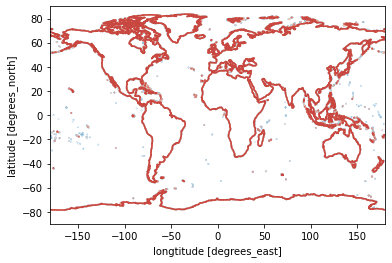

In [12]:
dset_landsea['cell_sea_land_mask'].plot.contour()

In [16]:
# shift by cartopy: https://stackoverflow.com/questions/59584276/cartopy-set-extent-with-central-longitude-180
def contf_tmean(title, data, label, colormap, extend, varmin, varmax, space, lat_min, lat_max, lon_min, lon_max):
    proj = ccrs.PlateCarree(central_longitude=180) # Create Mollweide projections
    fig = plt.figure(figsize=(18, 12))
    ax = fig.add_subplot(111, projection=proj)
    minlon = lon_min + 5 + 180
    maxlon = lon_max - 5 + 180
    ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],ccrs.PlateCarree())
    #plot = data.where((data.lat >= lat_min) & (data.lat <= lat_max) & (data.lon >= lon_min) & (data.lon <= lon_max)).plot(
    plot = data.plot(
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      cmap=colormap,
                      vmin=varmin,
                      vmax=varmax,
                     # cbar_kwargs={'label': 'Surface Temperature [K]',
                     #              'extend': 'both',
                     #              'shrink': .5,
                     #              'orientation': 'horizontal'},
                      add_colorbar=False
                     )
    dset_landsea['cell_sea_land_mask'].plot.contour(ax=ax, transform=ccrs.PlateCarree())
    bounds = np.linspace(varmin,varmax, space)
    cb = plt.colorbar(plot, orientation="horizontal", fraction=0.05, pad=0.10, extend=extend,ticks=bounds, boundaries=bounds)
    cb.set_label(label=label, size=15, weight='bold')
    cb.ax.tick_params(labelsize=15)
    cb.ax.set_xticklabels(bounds,rotation=90)
    ax.coastlines(resolution='10m', lw=0.51)
    gl=ax.gridlines(draw_labels=True, crs=proj)
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 15}, {'fontsize': 15}
    ax.yaxis.tick_right() 
    ax.set_title(title, y=1.1, fontsize=20, weight='bold')
    _ = fig.subplots_adjust(left=0.01, right=0.98, hspace=0, wspace=0, top=0.9, bottom=0.25)

In [24]:
gray_new = colormap_create('gray',18,0,1)
YlGn_new = colormap_create('Greens',18,0,1)

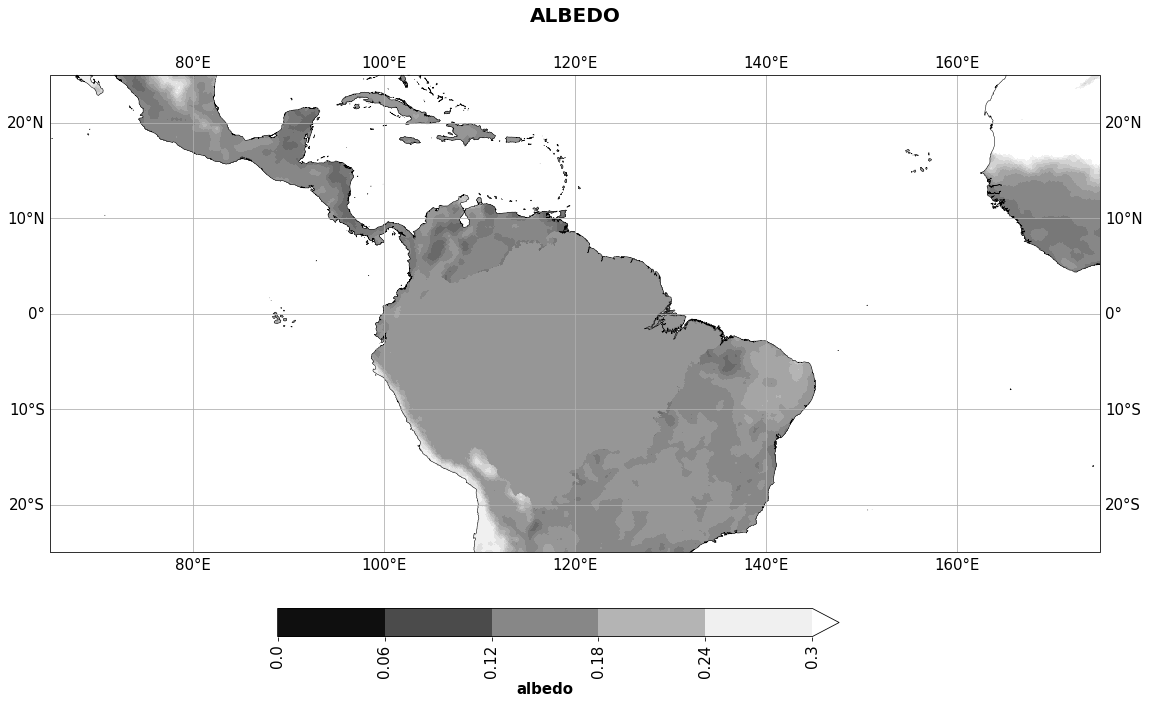

In [40]:
contf_tmean(f'ALBEDO',albedo_mask,'albedo',gray_new, 'max', 0, 0.3, 6, -30,30, 60,180)

In [21]:
forest_fract_mask.max()

<xarray.DataArray 'forest_fract' ()>
array(0.97798754)
Coordinates:
    time     object 0001-01-31 00:00:00

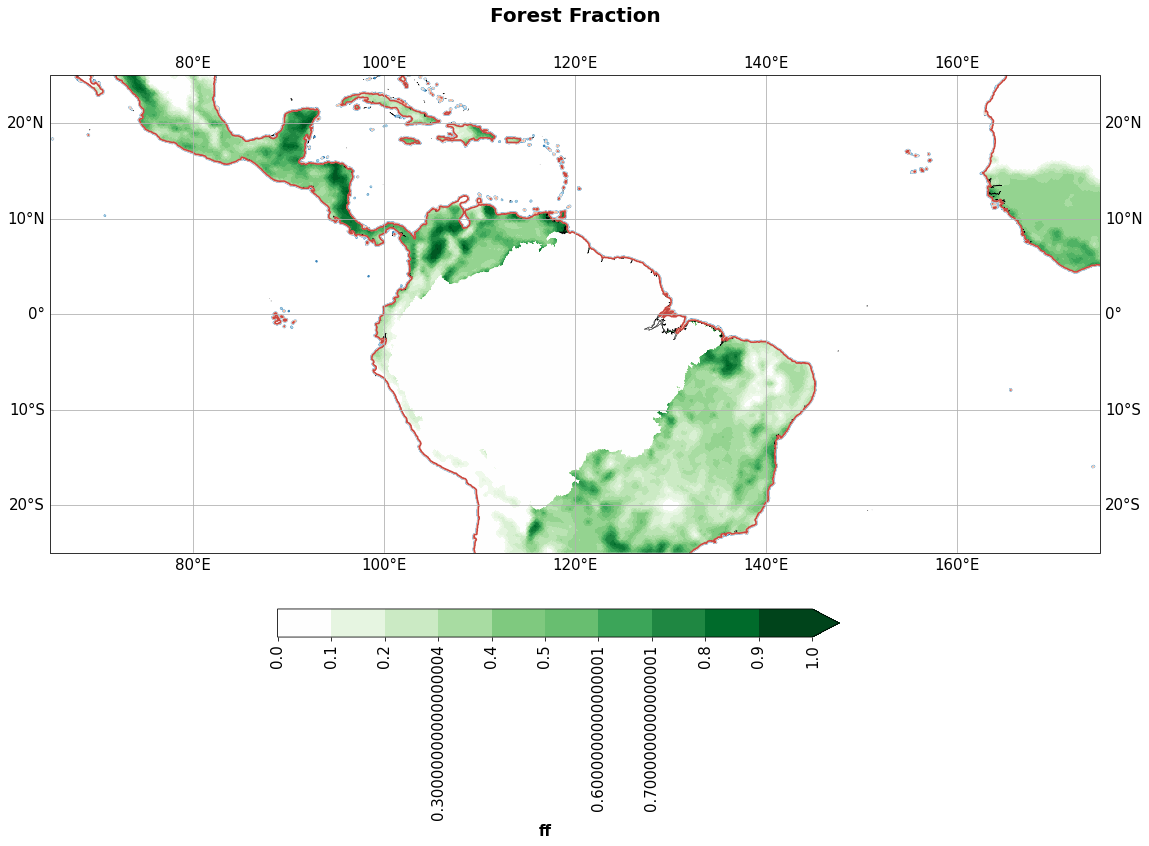

In [25]:
contf_tmean(f'Forest Fraction',forest_fract[:,:],'ff',YlGn_new, 'max', 0, 1, 11, -30,30, 60,180)

# 1st step: Load original data - regridded

In [5]:
file_1 = '/work/mh0731/m300948/AMDEF/REGRID_BC/amz_100def/scena_100_implement/bc_land_phys_new.nc'  # original bc_land after the regrid
dset_1 = xr.open_dataset(file_1) # if it is ncfile
var_names = ['lai_clim','roughness_length','albedo','forest_fract']
dset_1_subset = dset_1[var_names].persist()
dset_1_subset

<xarray.Dataset>
Dimensions:           (time: 12, cell: 20971520)
Coordinates:
  * time              (time) object 0001-01-31 00:00:00 ... 0001-12-31 00:00:00
    clon              (cell) float64 ...
    clat              (cell) float64 ...
Dimensions without coordinates: cell
Data variables:
    lai_clim          (time, cell) float64 ...
    roughness_length  (cell) float64 ...
    albedo            (cell) float64 ...
    forest_fract      (cell) float64 ...

In [6]:
file_2 = '/work/mh0731/m300948/AMDEF/REGRID_BC/amz_100def/scena_100_implement/bc_land_soil_new.nc'
dset_2 = xr.open_dataset(file_2) # if it is ncfile
var_names = ['root_depth']
dset_2_subset = dset_2[var_names].persist()
dset_2_subset

<xarray.Dataset>
Dimensions:     (cell: 20971520)
Coordinates:
    clon        (cell) float64 ...
    clat        (cell) float64 ...
Dimensions without coordinates: cell
Data variables:
    root_depth  (cell) float64 ...

In [7]:
file_3 = '/work/mh0731/m300948/AMDEF/REGRID_BC/amz_100def/scena_100_implement/bc_land_frac_new.nc'
dset_3 = xr.open_dataset(file_3) # if it is ncfile
var_names = ['veg_ratio_max']
dset_3_subset = dset_3[var_names].persist()
dset_3_subset

<xarray.Dataset>
Dimensions:        (cell: 20971520)
Coordinates:
    clon           (cell) float64 ...
    clat           (cell) float64 ...
Dimensions without coordinates: cell
Data variables:
    veg_ratio_max  (cell) float64 ...

# 2nd Step: Load biome / LAI masking data

In [5]:
file2 = '/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc'
file3 = '/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/amz_lai.nc'

In [6]:
dset2 = xr.open_dataset(file2) # if it is ncfile
dset3 = xr.open_dataset(file3) # if it is ncfile

In [7]:
mask_val = ['AMAZON_BIOMES']
dset_mask_biome = dset2[mask_val].persist()
dset_mask_biome

<xarray.Dataset>
Dimensions:        (latitude: 550, longitude: 720)
Coordinates:
  * latitude       (latitude) float32 -18.08 -18.02 -17.98 ... 9.275 9.325 9.375
  * longitude      (longitude) float32 -79.97 -79.93 -79.88 ... -44.08 -44.03
Data variables:
    AMAZON_BIOMES  (latitude, longitude) int8 ...

In [8]:
mask_val = ['lai_clim']
dset_mask_lai = dset3[mask_val].persist()
dset_mask_lai

<xarray.Dataset>
Dimensions:   (time: 12, lat: 561, lon: 839)
Coordinates:
  * time      (time) object 0001-01-31 00:00:00 ... 0001-12-31 00:00:00
  * lon       (lon) float64 -79.95 -79.9 -79.85 -79.8 ... -38.15 -38.1 -38.05
  * lat       (lat) float64 -18.05 -18.0 -17.95 -17.9 ... 9.8 9.85 9.9 9.95
Data variables:
    lai_clim  (time, lat, lon) float64 ...
Attributes: (12/16)
    CDI:                          Climate Data Interface version 1.9.10 (http...
    institution:                  Max Planck Institute for Meteorology
    Conventions:                  CF-1.0
    title:                        initial surface data for JSBACH
    refyear_for_cover_types:      2015
    refyear_for_cover_fractions:  2015
    ...                           ...
    references:                   Hagemann, S. & Stacke, T. (2015): Impact of...
    cdo_openmp_thread_number:     8
    history_of_appended_files:    Mon Aug 30 12:40:34 2021: Appended file gau...
    history:                      Mon Apr 25 17:27:47 2022: cdo select,name=l...
    NCO:                          4.6.7
    CDO:                          Climate Data Operators version 1.9.10 (http...

# 3rd Step Interpolation
## interpolate with biome basin

In [18]:
####### Basin/Biome masking file from GIS
ABinterp_biome = dset_mask_biome.interp(latitude=dset_1_subset.clat, longitude=dset_1_subset.clon)
AB_biome=ABinterp_biome['AMAZON_BIOMES'].to_numpy()

## interpolate with lai 

In [20]:
####### Biome masking file from original file
ABinterp_lai = dset_mask_lai.interp(lat=dset_1_subset.clat, lon=dset_1_subset.clon)
AB_lai=dset_mask_lai['lai_clim'].to_numpy()

# 4th Step Masking 
## 4-1) masking original data with biome masking file

In [ ]:
# phys
bcn1 = xr.where(ABinterp_biome==0,2.7,dset_subset['lai_clim'])
bcn2 = xr.where(ABinterp_biome==0,0.85,dset_subset['veg_fract'])
bcn3 = xr.where(ABinterp_biome==0,0.05,dset_subset['roughness_length'])
bcn4 = xr.where(ABinterp_biome==0,0.18,dset_subset['albedo'])

In [ ]:
# root
bcn1 = xr.where(ABinterp_biome==0,0.6,dset_subset['root_depth'])

In [ ]:
# phys
bcn1 = xr.where(ABinterp_biome==0,0.85,dset_subset['veg_ratio_max'])

In [ ]:
# forest fraction
bcn1 = xr.where(ABinterp_biome==0,0,dset_subset['forest_fract'])

# 2nd Step: Load biome masking data

In [4]:
file_m1 = '/work/mh0731/m300948/AMDEF/REGRID_BC/amz_100def/biome_100def.nc'
dset_m1 = xr.open_dataset(file_m1) # if it is ncfile
var_names = ['lai_clim','roughness_length','albedo']
dset_m1_subset = dset_m1[var_names].persist()
dset_m1_subset

<xarray.Dataset>
Dimensions:           (lat: 3600, lon: 7200, time: 12)
Coordinates:
    latitude          (lat) float64 ...
    longitude         (lon) float64 ...
  * lat               (lat) float64 -89.95 -89.9 -89.85 ... 89.9 89.95 90.0
  * lon               (lon) float64 -179.9 -179.9 -179.8 ... 179.9 180.0 180.0
  * time              (time) object 0001-01-31 00:00:00 ... 0001-12-31 00:00:00
Data variables:
    lai_clim          (lat, lon, time) float64 ...
    roughness_length  (lat, lon) float64 ...
    albedo            (lat, lon) float64 ...

In [5]:
file_m2 = '/work/mh0731/m300948/AMDEF/REGRID_BC/amz_100def/biome_root_100def.nc'
dset_m2 = xr.open_dataset(file_m2) # if it is ncfile
var_names = ['root_depth']
dset_m2_subset = dset_m2[var_names].persist()
dset_m2_subset

<xarray.Dataset>
Dimensions:     (lat: 3600, lon: 7200)
Coordinates:
    latitude    (lat) float64 ...
    longitude   (lon) float64 ...
  * lat         (lat) float64 -89.95 -89.9 -89.85 -89.8 ... 89.9 89.95 90.0
  * lon         (lon) float64 -179.9 -179.9 -179.8 -179.8 ... 179.9 180.0 180.0
Data variables:
    root_depth  (lat, lon) float64 ...

In [6]:
# veg_fract no longer exist, but "veg_ratio_max"
file_m3 = '/work/mh0731/m300948/AMDEF/REGRID_BC/amz_100def/biome_vegf_100def.nc'
dset_m3 = xr.open_dataset(file_m3) # if it is ncfile
var_names = ['veg_ratio_max']
dset_m3_subset = dset_m3[var_names].persist()
dset_m3_subset

<xarray.Dataset>
Dimensions:        (lat: 3600, lon: 7200)
Coordinates:
    latitude       (lat) float64 ...
    longitude      (lon) float64 ...
  * lat            (lat) float64 -89.95 -89.9 -89.85 -89.8 ... 89.9 89.95 90.0
  * lon            (lon) float64 -179.9 -179.9 -179.8 ... 179.9 180.0 180.0
Data variables:
    veg_ratio_max  (lat, lon) float64 ...

In [7]:
# veg_fract no longer exist, but "veg_ratio_max"
file_m4 = '/work/mh0731/m300948/AMDEF/REGRID_BC/amz_100def/biome_forf_100def.nc'
dset_m4 = xr.open_dataset(file_m4) # if it is ncfile
var_names = ['forest_fract']
dset_m4_subset = dset_m4[var_names].persist()
dset_m4_subset

<xarray.Dataset>
Dimensions:       (lat: 3600, lon: 7200)
Coordinates:
    latitude      (lat) float64 ...
    longitude     (lon) float64 ...
  * lat           (lat) float64 -89.95 -89.9 -89.85 -89.8 ... 89.9 89.95 90.0
  * lon           (lon) float64 -179.9 -179.9 -179.8 ... 179.9 180.0 180.0
Data variables:
    forest_fract  (lat, lon) float64 ...

# 3rd Step: Interpolation

In [ ]:
####### Basin/Biome masking file from GIS
#ABinterp_biome = dset_mask_biome.interp(latitude=dset_subset.lat, longitude=dset_subset.lon)
#AB_biome=ABinterp_biome['AMAZON_BIOMES'].to_numpy()
#fig=plt.figure(figsize=(12,6))
#plt.contourf(AB_biome[:,:])
#plt.colorbar()

####### Biome masking file from original file - interpolate with LAI data
ABinterp_lai = dset_mask_lai.interp(lat=dset_m1_subset.lat, lon=dset_m1_subset.lon)
AB_lai=dset_mask_lai['lai_clim'].to_numpy()
fig=plt.figure(figsize=(12,6))
plt.contourf(AB_lai[0,:,:])
plt.colorbar()

# Masking data for plotting

In [21]:
YlGnBu_new = colormap_create('YlGnBu',18,0,1)
YlGn_new = colormap_create('YlGn',18,0,1)
YlOrBr_new = colormap_create('YlOrBr',18,0,1)

In [18]:
# 5km for input SST [ICON 5km to 10km to match the IMERGE]
file_mask_5km = '/work/mh0731/m300948/dpp_0066/bc_land_phys_regrid.nc'
dset_5km = xr.open_dataset(file_mask_5km)
var_names = ['lai_clim']
dset_mask_5km = dset_5km[var_names].persist()
dset_mask_5km

<xarray.Dataset>
Dimensions:   (time: 12, lat: 3600, lon: 7200)
Coordinates:
  * time      (time) object 0001-01-31 00:00:00 ... 0001-12-31 00:00:00
  * lon       (lon) float64 -179.9 -179.9 -179.8 -179.8 ... 179.9 180.0 180.0
  * lat       (lat) float64 -89.95 -89.9 -89.85 -89.8 ... 89.85 89.9 89.95 90.0
Data variables:
    lai_clim  (time, lat, lon) float64 ...
Attributes: (12/16)
    CDI:                          Climate Data Interface version 1.9.10 (http...
    Conventions:                  CF-1.0
    institution:                  Max Planck Institute for Meteorology
    title:                        initial surface data for JSBACH
    refyear_for_cover_types:      2015
    refyear_for_cover_fractions:  2015
    ...                           ...
    references:                   Hagemann, S. & Stacke, T. (2015): Impact of...
    cdo_openmp_thread_number:     8
    history_of_appended_files:    Mon Aug 30 12:40:34 2021: Appended file gau...
    history:                      Tue May 10 14:43:30 2022: cdo -remap,gridde...
    NCO:                          4.6.7
    CDO:                          Climate Data Operators version 1.9.10 (http...

In [19]:
dset_mask_5km=dset_mask_5km['lai_clim']

# nan to 100 ==> reference data to mask the other dataset
dset_mask_5km=dset_mask_5km.fillna(100)

In [35]:
print(np.shape(dset_mask_5km))
print(np.shape(albedo_input))

(12, 3600, 7200)
(3600, 7200)


# Masking data (Converted one, Original one)

## 1) Converted one

In [24]:
#Albedo=dset_m1_subset['albedo'].to_numpy()
albedo_input=dset_1_subset['albedo']

# remove the error message "indices difference between ICON and Masking file"
albedo_input['lat'] = dset_mask_5km['lat']
albedo_input['lon'] = dset_mask_5km['lon']
#new_Albedo = np.ma.masked_array(Albedo[:,:], m.mask)

albedo_input_mask=albedo_input.where(dset_mask_5km.isel(time=0)!=100,np.nan)

ValueError: cannot add coordinates with new dimensions to a DataArray

In [66]:
#Albedo=dset_m1_subset['albedo'].to_numpy() ['lai_clim','roughness_length','albedo','forest_fract']
lai_input=dset_m1_subset['lai_clim']
roughness_input=dset_m1_subset['roughness_length']
forestf_input=dset_m4_subset['forest_fract']
veg_input=dset_m3_subset['veg_ratio_max']
root_input=dset_m2_subset['root_depth']

lai_input['lat'] = dset_mask_5km['lat']
lai_input['lon'] = dset_mask_5km['lon']
roughness_input['lat'] = dset_mask_5km['lat']
roughness_input['lon'] = dset_mask_5km['lon']
forestf_input['lat'] = dset_mask_5km['lat']
forestf_input['lon'] = dset_mask_5km['lon']
veg_input['lat'] = dset_mask_5km['lat']
veg_input['lon'] = dset_mask_5km['lon']
root_input['lat'] = dset_mask_5km['lat']
root_input['lon'] = dset_mask_5km['lon']

lai_input_mask=lai_input.where(dset_mask_5km.isel(time=0)!=100,np.nan)
roughness_input_mask=roughness_input.where(dset_mask_5km.isel(time=0)!=100,np.nan)
forestf_input_mask=forestf_input.where(dset_mask_5km.isel(time=0)!=100,np.nan)
veg_input_mask=veg_input.where(dset_mask_5km.isel(time=0)!=100,np.nan)
root_input_mask=root_input.where(dset_mask_5km.isel(time=0)!=100,np.nan)

## 2) Original one

In [59]:
#Albedo=dset_m1_subset['albedo'].to_numpy()
albedo_orig=dset_1_subset['albedo']

# remove the error message "indices difference between ICON and Masking file"
albedo_orig['lat'] = dset_mask_5km['lat']
albedo_orig['lon'] = dset_mask_5km['lon']
#new_Albedo = np.ma.masked_array(Albedo[:,:], m.mask)

albedo_orig_mask=albedo_orig.where(dset_mask_5km.isel(time=0)!=100,np.nan)

In [97]:
#Albedo=dset_m1_subset['albedo'].to_numpy() ['lai_clim','roughness_length','albedo','forest_fract']
lai_orig=dset_1_subset['lai_clim']
roughness_orig=dset_1_subset['roughness_length']
forestf_orig=dset_1_subset['forest_fract']
veg_orig=dset_3_subset['veg_ratio_max']
root_orig=dset_2_subset['root_depth']

lai_orig['lat'] = dset_mask_5km['lat']
lai_orig['lon'] = dset_mask_5km['lon']
roughness_orig['lat'] = dset_mask_5km['lat']
roughness_orig['lon'] = dset_mask_5km['lon']
forestf_orig['lat'] = dset_mask_5km['lat']
forestf_orig['lon'] = dset_mask_5km['lon']
veg_orig['lat'] = dset_mask_5km['lat']
veg_orig['lon'] = dset_mask_5km['lon']
root_orig['lat'] = dset_mask_5km['lat']
root_orig['lon'] = dset_mask_5km['lon']

lai_orig_mask=lai_orig.where(dset_mask_5km.isel(time=0)!=100,np.nan)
roughness_orig_mask=roughness_orig.where(dset_mask_5km.isel(time=0)!=100,np.nan)
forestf_orig_mask=forestf_orig.where(dset_mask_5km.isel(time=0)!=100,np.nan)
veg_orig_mask=veg_orig.where(dset_mask_5km.isel(time=0)!=100,np.nan)
root_orig_mask=root_orig.where(dset_mask_5km.isel(time=0)!=100,np.nan)

# Plotting

In [69]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def contf_diff(title, data, colormap, varmin, varmax, space):
    lats = dset_m4_subset.lat
    lons = dset_m4_subset.lon

    fig = plt.figure(figsize=[5,5],facecolor='w')
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_extent([-175+180,175+180,-30,30])
    ax.coastlines('50m',linewidth=0.8)
    grid_lines = ax.gridlines(draw_labels=True)
    grid_lines.xformatter = LONGITUDE_FORMATTER
    grid_lines.yformatter = LATITUDE_FORMATTER

    m = ax.pcolormesh(lons,lats,data,cmap=colormap,vmin=varmin,vmax=varmax,transform=ccrs.PlateCarree())
    cbar = plt.colorbar(m,fraction=0.1, pad=0.04,extend='both',location='right')
    cbar_ticks = np.linspace(varmin, varmax, num=space)
    cbar.set_ticks(cbar_ticks)

    ax.set_title(title,y=1.1,fontsize=20,fontweight='bold')
    plt.show()

In [93]:
gray_new = colormap_create('gray',18,0,1)
YlGn_new = colormap_create('YlGn',9,0,1)
YlOrBr_new = colormap_create('YlOrBr',9,0,1)
RdPu_new = colormap_create('RdPu',11,0,1)

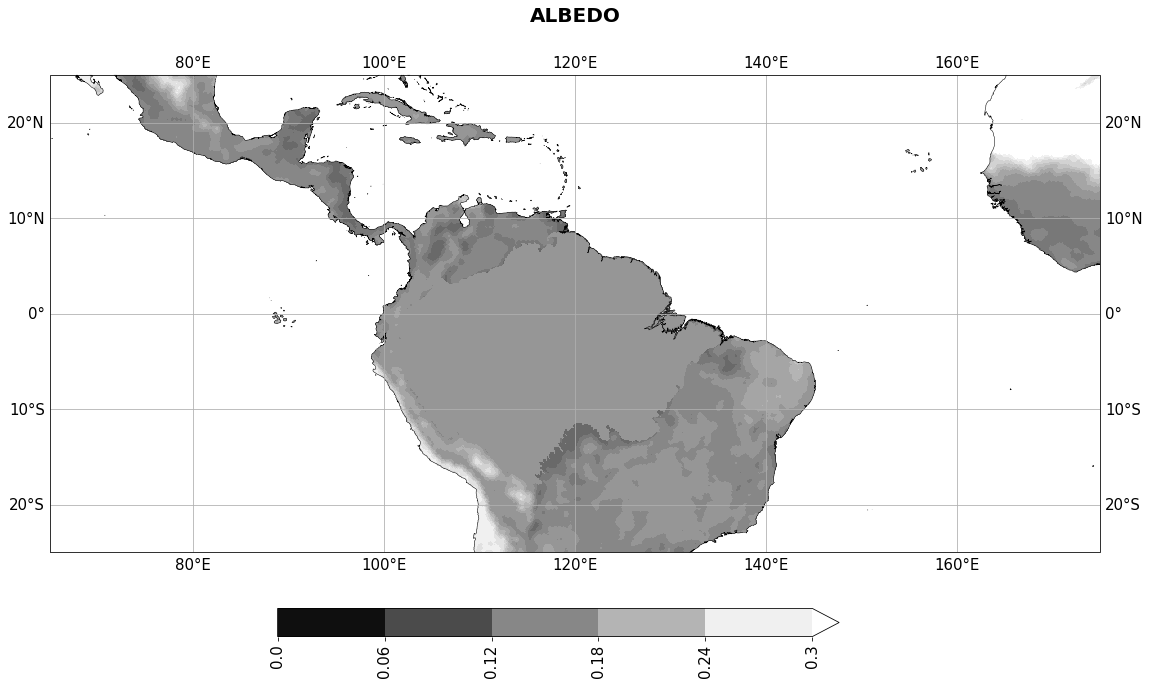

In [62]:
contf_tmean(f'ALBEDO',albedo_input_mask,'',gray_new, 'max', 0, 0.3, 6, -30,30, 60,180)

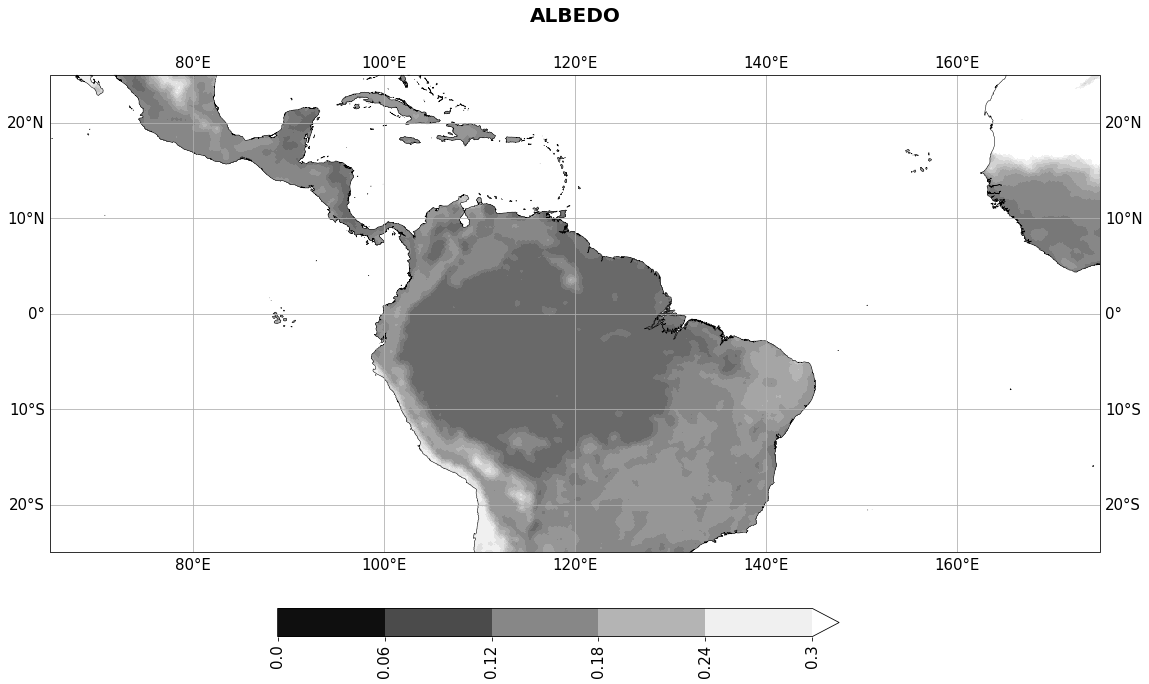

In [63]:
contf_tmean(f'ALBEDO',albedo_orig_mask,'',gray_new, 'max', 0, 0.3, 6, -30,30, 60,180)

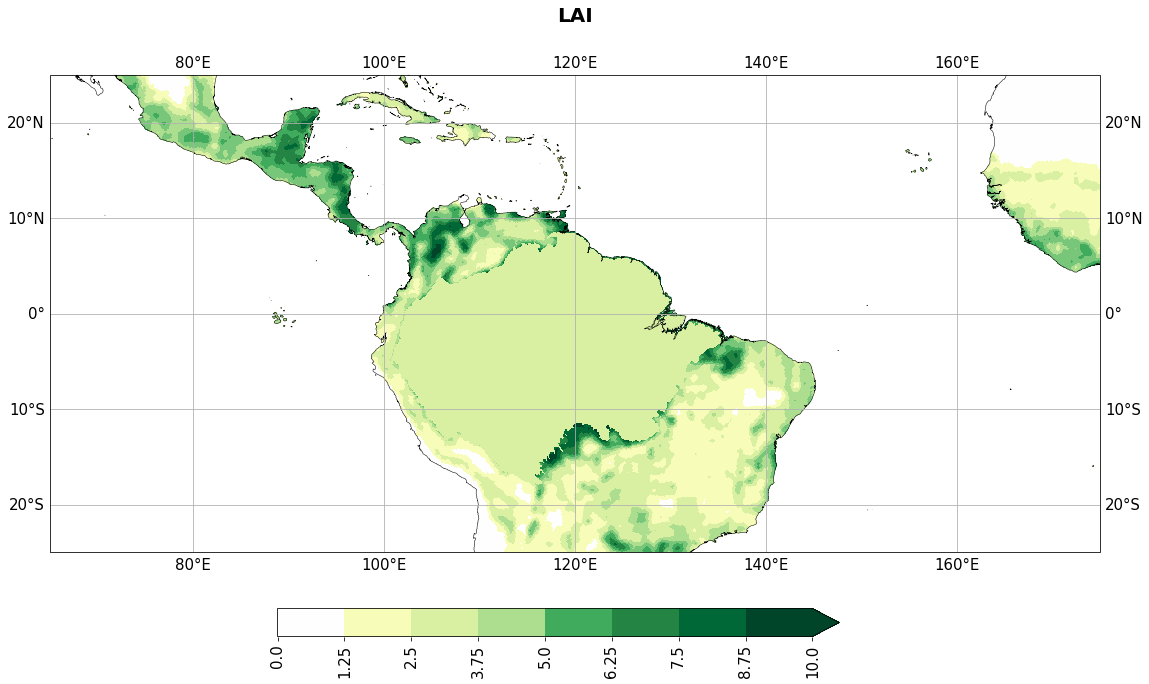

In [83]:
contf_tmean(f'LAI',lai_input[:,:,6],'',YlGn_new, 'max', 0, 10, 9, -30,30, 60,180)

In [104]:
print(np.shape(lai_orig))

(12, 3600, 7200)


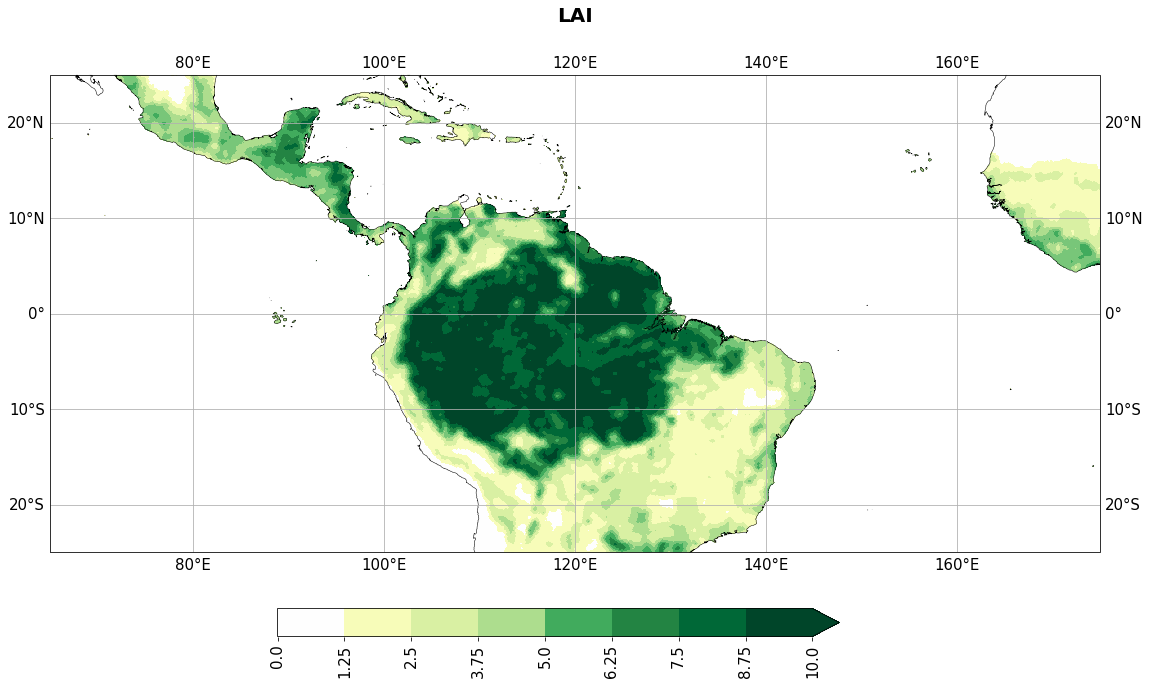

In [105]:
contf_tmean(f'LAI',lai_orig[6,:,:],'',YlGn_new, 'max', 0, 10, 9, -30,30, 60,180)

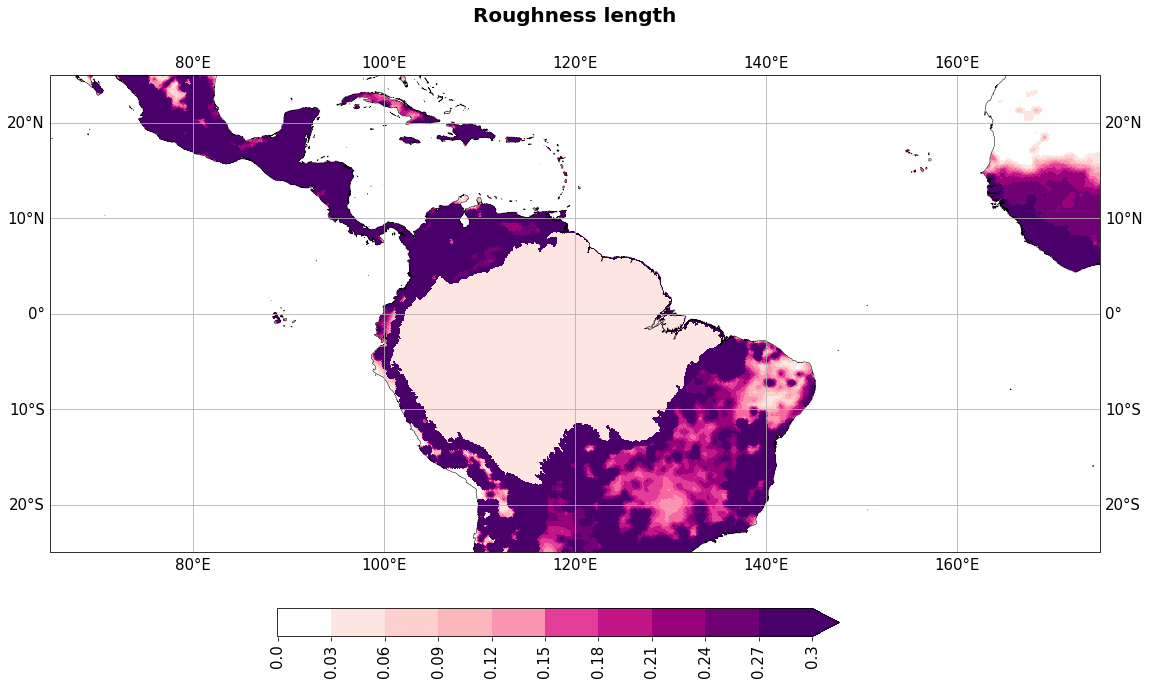

In [94]:
contf_tmean(f'Roughness length',roughness_input_mask,'',RdPu_new, 'max', 0, 0.3, 11, -30,30, 60,180)

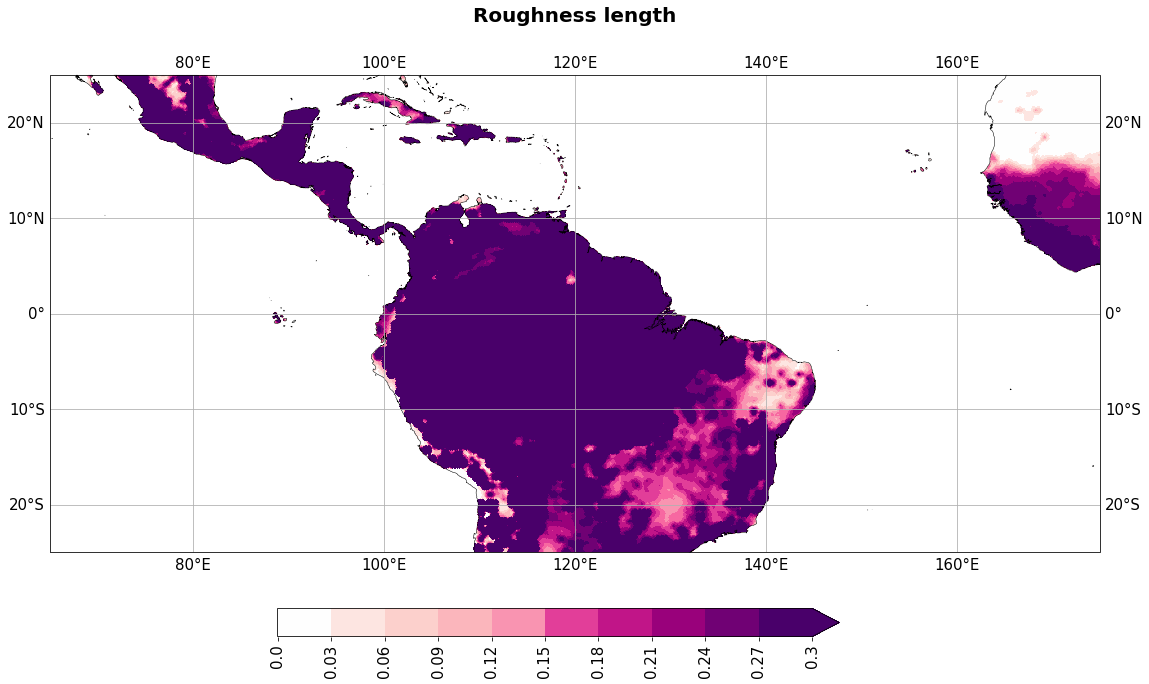

In [99]:
contf_tmean(f'Roughness length',roughness_orig_mask,'',RdPu_new, 'max', 0, 0.3, 11, -30,30, 60,180)

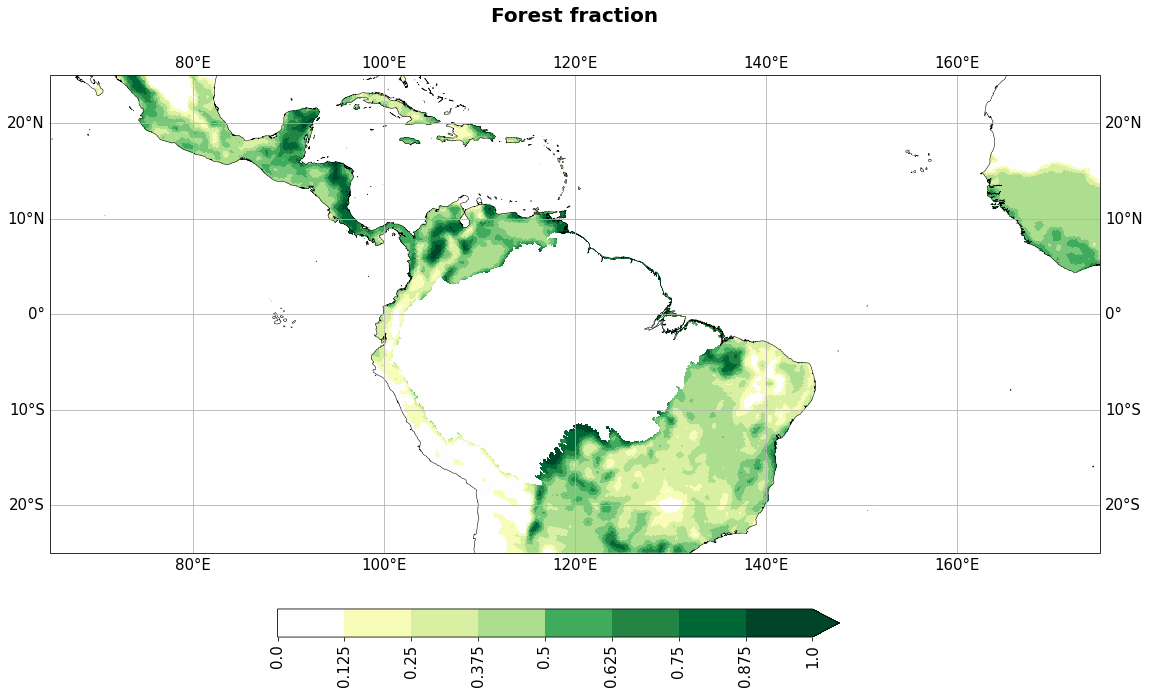

In [85]:
contf_tmean(f'Forest fraction',forestf_input_mask,'',YlGn_new, 'max', 0, 1.0, 9, -30,30, 60,180)

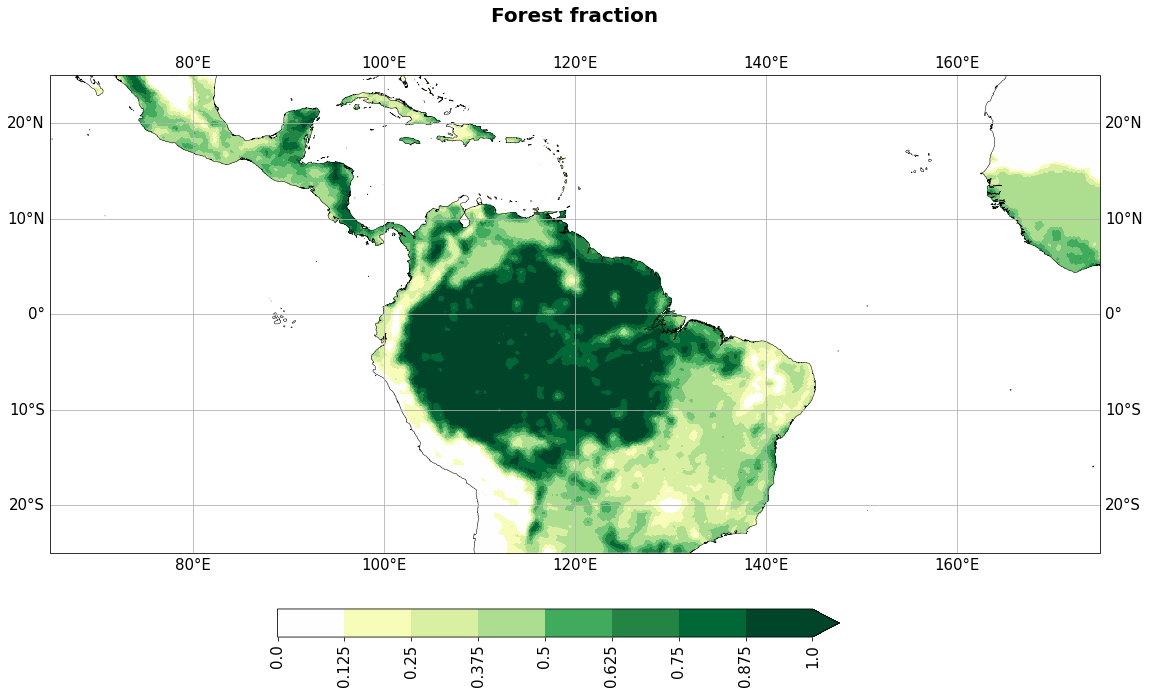

In [100]:
contf_tmean(f'Forest fraction',forestf_orig_mask,'',YlGn_new, 'max', 0, 1.0, 9, -30,30, 60,180)

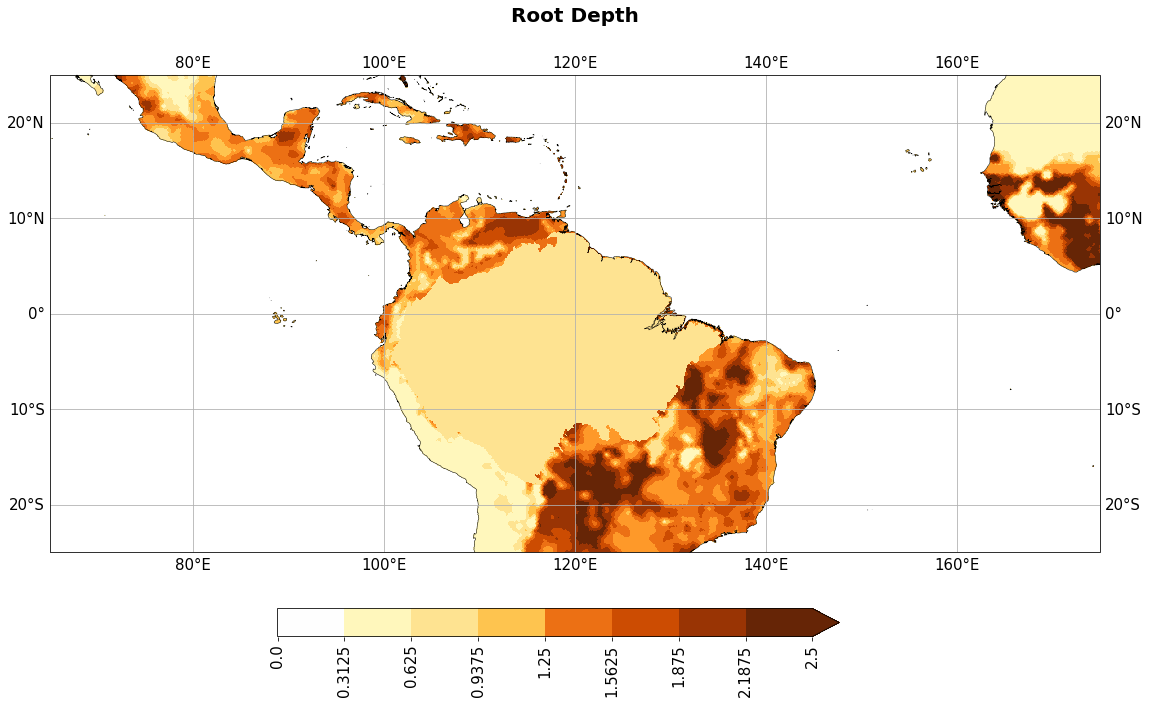

In [87]:
contf_tmean(f'Root Depth',root_input_mask,'',YlOrBr_new, 'max', 0, 2.5, 9, -30,30, 60,180)

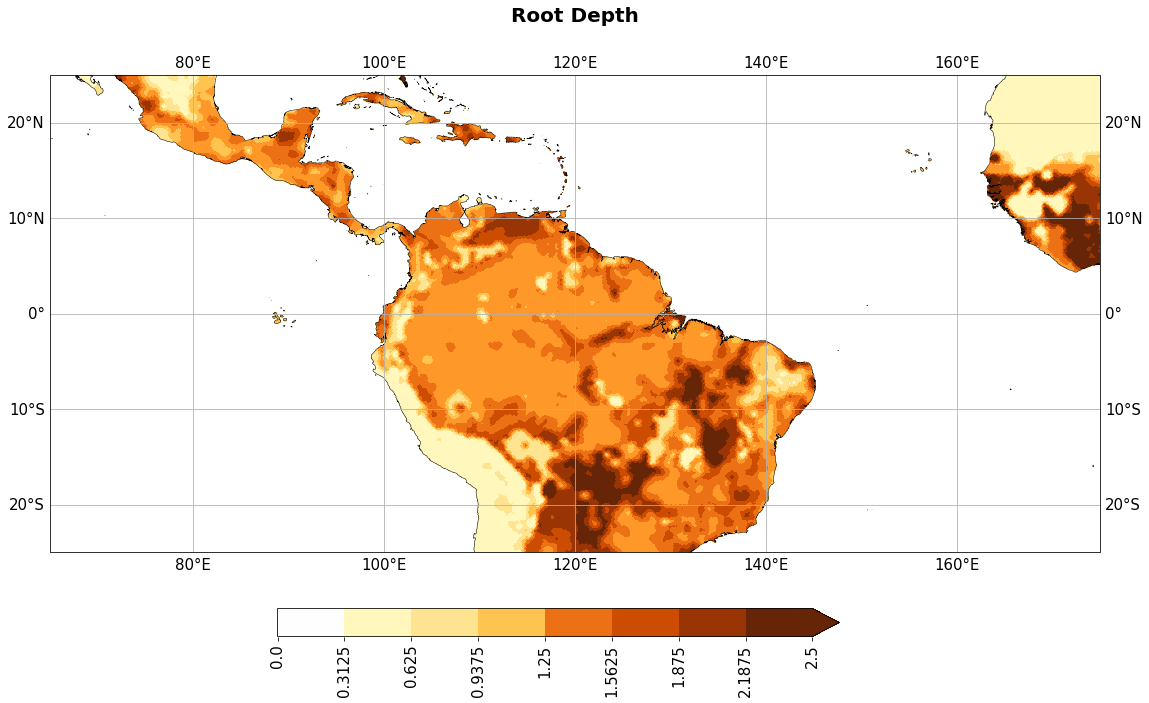

In [101]:
contf_tmean(f'Root Depth',root_orig_mask,'',YlOrBr_new, 'max', 0, 2.5, 9, -30,30, 60,180)

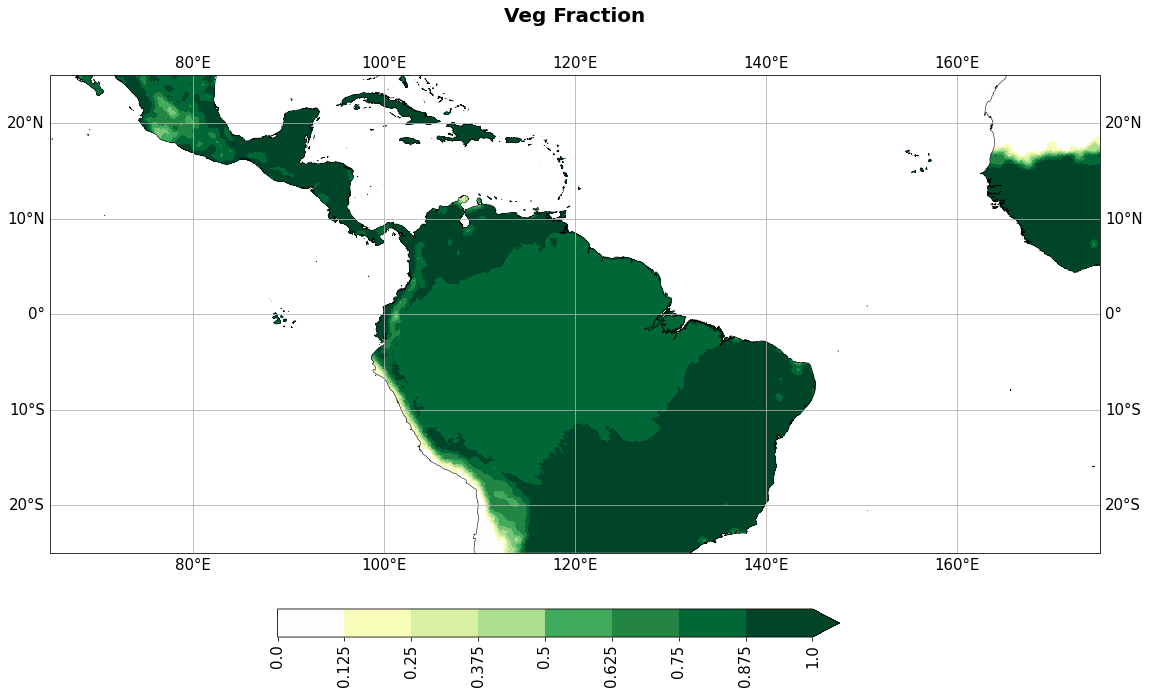

In [88]:
contf_tmean(f'Veg Fraction',veg_input_mask,'',YlGn_new, 'max', 0, 1.0, 9, -30,30, 60,180)

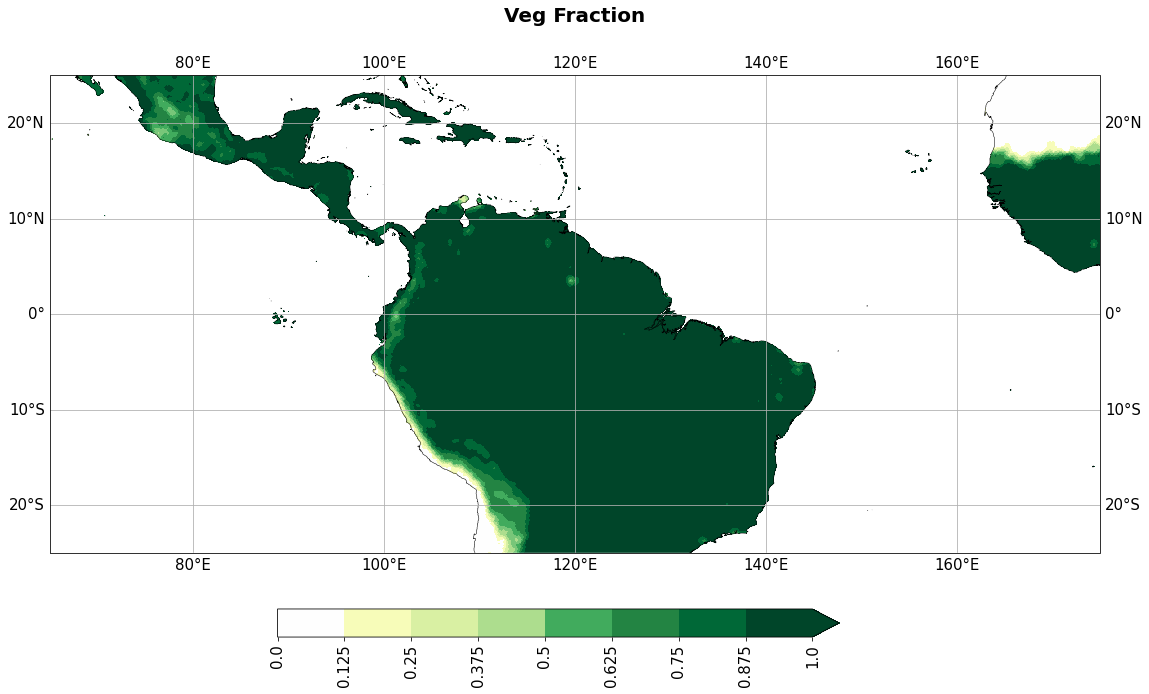

In [102]:
contf_tmean(f'Veg Fraction',veg_orig_mask,'',YlGn_new, 'max', 0, 1.0, 9, -30,30, 60,180)